In [1]:
import sys, os
from models import FCN_model
from preprocessing import ConstantLengthDataGenerator
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import mlflow
from preprocessing.utils import plot
import tensorflow as tf
mlflow.set_experiment("FCN")
mlflow.tensorflow.autolog()

In [2]:
data_path = "./data"
X, y = np.load(f"{data_path}/X.npy", allow_pickle=True), np.load(f"{data_path}/y.npy")
y.shape, X.shape

((60555, 1), (60555,))

In [3]:
mask = np.char.startswith(y, "GunPoint").reshape(-1)
y = y[mask, :]
X = X[mask]
mlflow.log_param("y.unique", np.unique(y))

array(['GunPointAgeSpan_1', 'GunPointAgeSpan_2',
       'GunPointMaleVersusFemale_1', 'GunPointMaleVersusFemale_2',
       'GunPointOldVersusYoung_1', 'GunPointOldVersusYoung_2',
       'GunPoint_1', 'GunPoint_2'], dtype='<U42')

In [4]:
y_encoder = sklearn.preprocessing.OneHotEncoder(categories="auto")
y = y_encoder.fit_transform(y.reshape(-1, 1)).toarray()
mlflow.log_param("y.shape", y.shape)
y.shape, X.shape

((456, 8), (456,))

In [5]:
number_of_classes = y.shape[1]
initial_learning_rate = 1e-4
output_directory = f"{data_path}/models/fcn/outputs"
batch_size = 256
os.makedirs(output_directory, exist_ok=True)

In [6]:
input_layer = keras.layers.Input(shape=(None, 1))
fcn_model = FCN_model(number_of_classes=number_of_classes)(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=fcn_model)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=3, decay_rate=1
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_schedule),
    metrics=["accuracy"],
)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         1536      
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         164096    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                             

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [17]:
vars(data_generator_train)

{'shuffle': True,
 'X': array([[-0.5429372554543925, -0.5428906043802982, -0.5429154127143213,
         ..., -0.6506643377808757, -0.6506545855392252,
         -0.6504391807631175],
        [-0.8093225917181005, -0.8133779796937161, -0.8140788648855536,
         ..., -1.0261540155156703, -1.0230385305243672,
         -1.0242257049902965],
        [-0.9040096172968096, -0.9047583094484385, -0.9056498675407445,
         ..., -0.8495695696771827, -0.8486937184132325,
         -0.8475976706552053],
        ...,
        [-0.6500558762098142, -0.6441422812617499, -0.6403243033857905,
         ..., -0.6425742256687615, -0.640805299387072,
         -0.6407967809447789],
        [-1.4462321353805936, -1.5097966714841562, -1.5589907258791893,
         ..., -1.1739655624902252, -1.1782676266844414,
         -1.178340770906229],
        [-0.6462791963270471, -0.6431525467366825, -0.6415887453502066,
         ..., -0.6066919983779928, -0.6076585656556736,
         -0.6021238959113775]], dtype=objec

In [9]:
kwargs = {"min_length": 256, "max_length": 256, "logging_call": mlflow.log_params}
data_generator_train = ConstantLengthDataGenerator(
    X_train, y_train, batch_size=batch_size, **kwargs
)
data_generator_val = ConstantLengthDataGenerator(
    X_val, y_val, batch_size=len(y_val), **kwargs
)
validation_data = next(data_generator_val)

In [10]:
history = model.fit(data_generator_train, epochs=10, validation_data=validation_data
)

Epoch 1/60
110/110 [==============================] - 21s 177ms/step - loss: 2.0141 - accuracy: 0.2205 - val_loss: 2.1161 - val_accuracy: 0.1228
Epoch 2/60
110/110 [==============================] - 20s 185ms/step - loss: 1.9172 - accuracy: 0.2463 - val_loss: 2.1275 - val_accuracy: 0.1754
Epoch 3/60
110/110 [==============================] - 19s 173ms/step - loss: 1.8614 - accuracy: 0.2795 - val_loss: 2.1129 - val_accuracy: 0.1842
Epoch 4/60
110/110 [==============================] - 18s 167ms/step - loss: 1.8173 - accuracy: 0.2847 - val_loss: 2.0518 - val_accuracy: 0.1930
Epoch 5/60
110/110 [==============================] - 19s 168ms/step - loss: 1.7912 - accuracy: 0.3125 - val_loss: 1.9503 - val_accuracy: 0.2544
Epoch 6/60
110/110 [==============================] - 18s 165ms/step - loss: 1.7696 - accuracy: 0.3139 - val_loss: 1.9681 - val_accuracy: 0.2105
Epoch 7/60
110/110 [==============================] - 22s 196ms/step - loss: 1.7527 - accuracy: 0.3389 - val_loss: 1.8636 - val_ac

110/110 [==============================] - 21s 191ms/step - loss: 1.4472 - accuracy: 0.3938 - val_loss: 1.7759 - val_accuracy: 0.1842
Epoch 58/60
110/110 [==============================] - 22s 199ms/step - loss: 1.4199 - accuracy: 0.4068 - val_loss: 1.6995 - val_accuracy: 0.2632
Epoch 59/60
110/110 [==============================] - 20s 185ms/step - loss: 1.4277 - accuracy: 0.3901 - val_loss: 1.8414 - val_accuracy: 0.2281
Epoch 60/60
1/1 [==============================] - 0s 311ms/step


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmpo6tdgjvt\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmpo6tdgjvt\model\data\model\assets
2023/01/23 11:15:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pacyn\miniconda3\envs\uni\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


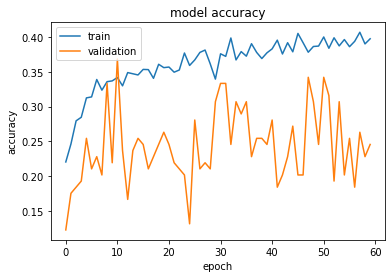

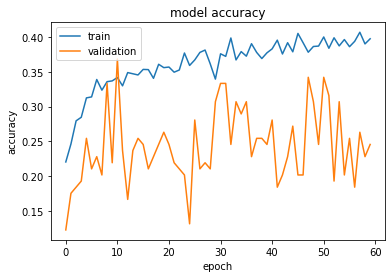

In [11]:
figure = plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [12]:
mlflow.log_figure(figure, "data/figures/acc.png")

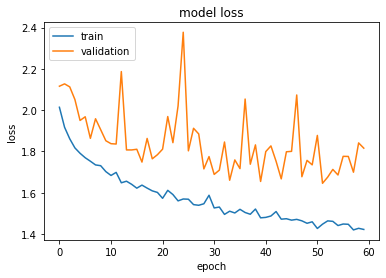

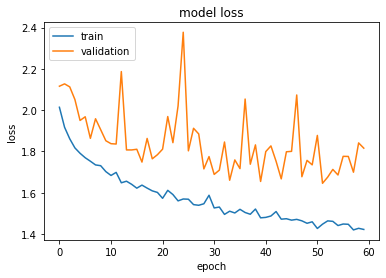

In [13]:
figure = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [14]:
mlflow.log_figure(figure, "data/figures/loss.png")

In [15]:
mlflow.log_artifact("models")
mlflow.log_artifact("preprocessing")

In [16]:
mlflow.end_run()